In [1]:
pip install torch torchvision

In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.7 MB/s eta 0:00:00


In [3]:
!pip install matplotlib

In [4]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'CRL_moon.ipynb', 'CRL_moon_cifar.ipynb', 'Cifar_baseline.ipynb', 'Cifar_baseline_ResNet.ipynb', 'DAC+Dropout_incomplete.ipynb', 'DAC+Temp.ipynb', 'DAC+Temp_Cifar.ipynb', 'DAC+Temp_Cifar_dropout_swin.ipynb', 'DAC+Temp_Cifar_mixup_labelsmoothing_swin.ipynb', 'DAC+Temp_Cifar_swin.ipynb', 'Dropout.ipynb', 'Dropout_cifar.ipynb', 'FocalLoss.ipynb', 'FocalLoss_cifar.ipynb', 'LabelSmoothing.ipynb', 'LabelSmoothing_cifar.ipynb', 'Mixup.ipynb', 'Mixup_cifar.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'model', 'py_code', 'result_auroc_OD.json', 'result_auroc_OD_CRL.json', 'result_auroc_OD_LS.json', 'result_auroc_OD_baseline.json', 'result_auroc_OD_dropout.json', 'result_auroc_OD_mixup.json', 'results_DAC_temp.json', 'results_DAC_temp_cifar.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_CRL.json', 'results_ECE_CRL_cifar.json', 'results_ECE_L

split the CIFAR-10 dataset into two non-overlapping halves: one half for training and validation (in-distribution), and the other half for testing (out-of-distribution). This code first splits the full CIFAR-10 training dataset into two halves. The first half is further split into training and validation subsets. The second half is used entirely for testing. This ensures that the training/validation and test datasets are completely non-overlapping.

In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.models as models
import torch
from torchvision.transforms import ToPILImage
import numpy as np
from PIL import Image

# Custom Dataset class to load images on-the-fly
class CIFARC_Dataset(Dataset):
    def __init__(self, data: np.ndarray, labels: list, transform=None):
        assert len(data) == len(labels)
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CIFAR images are in the format (channels, height, width)
        # We need to convert them to (height, width, channels) for PIL
        img = self.data[idx].transpose((1, 2, 0))  # Convert to HxWxC
        img = Image.fromarray(img.astype('uint8'), 'RGB')  # Convert to PIL Image
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

class CombinedCIFARCDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(f"Index out of range: {idx}")

        # Determine which dataset the index falls into
        dataset_idx = np.searchsorted(self.cumulative_lengths, idx, side='right')
        if dataset_idx > 0:
            relative_idx = idx - self.cumulative_lengths[dataset_idx - 1]
        else:
            relative_idx = idx

        return self.datasets[dataset_idx][relative_idx]


# Transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Get the labels from the CIFAR-10 test set
test_labels = full_test_dataset.targets

# Load CIFAR-10-C dataset
file_path = './data/CIFAR-10-C/zoom_blur.npy'  # Make sure this path is correct
cifar_c_data_blur = np.load(file_path)
cifar_c_data_blur = cifar_c_data_blur.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_blur = CIFARC_Dataset(data=cifar_c_data_blur[:500], labels=test_labels[:500], transform=transform)


file_path = './data/CIFAR-10-C/speckle_noise.npy'  # Make sure this path is correct
cifar_c_data_speckle = np.load(file_path)
cifar_c_data_speckle = cifar_c_data_speckle.transpose((0, 3, 1, 2))  # Reorder dimensions to match PyTorch's (batch_size, channels, height, width)

# Create an instance of the CIFARC_Dataset with the first 500 images and corresponding labels
cifar_c_dataset_speckle = CIFARC_Dataset(data=cifar_c_data_speckle[:500], labels=test_labels[:500], transform=transform)
# Instantiate the Combined Dataset with blur and speckle datasets
combined_cifar_c_dataset = CombinedCIFARCDataset([cifar_c_dataset_blur, cifar_c_dataset_speckle])
# Define DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_subset, test_subset = random_split(full_test_dataset, [len(full_test_dataset) // 2, len(full_test_dataset) - len(full_test_dataset) // 2])
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)
# Define a DataLoader for the combined dataset
OD_loader = DataLoader(combined_cifar_c_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import torch
import torch.nn as nn
import timm

class FeatureExtractorModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super(FeatureExtractorModel, self).__init__()
        # Copy all layers from the original model except the final classifier
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # In case the feature extractor model from timm has adaptive pooling
        # before the classifier, we add it back since we have removed the last
        # two layers (pooling and classifier) above.
        self.global_pool = backbone.global_pool

        # Assuming the last convolutional layer output is 7x7xN, where N is the number of channels
        # And assuming global average pooling is applied, we need to set the in_features to N
        # You need to verify N by checking the shape of the output from global_pool
        # Here we set in_features to 7 as per the printed output, which seems incorrect and should be the number of channels
        # This is likely a placeholder until the correct value of N is determined
        in_features = 7  # This should be the number of output channels after pooling, not 7

        # The new head (classifier) that will be trained on the new dataset
        self.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)

        if callable(self.global_pool):
            x = self.global_pool(x).flatten(start_dim=1)
        else:
            # If it's an attribute representing a string, replace it with the actual pooling operation
            x = torch.mean(x, dim=[2, 3])  # Average pooling for each channel

        # Now x should have a shape of (batch_size, num_channels), where num_channels is the depth of the feature map

        logits = self.head(x)
        return logits, x


#swin model initialization
# List all models
available_models = timm.list_models()
# Check if 'swin_small_patch4_window7_224' is in the list
print('swin_small_patch4_window7_224' in available_models)

# Example of creating a FeatureExtractorModel with the Swin Transformer backbone:
original_model = timm.create_model('swin_small_patch4_window7_224', pretrained=True)
num_classes = 10  # Replace with the number of classes in your dataset

# Initialize the feature extraction model
model = FeatureExtractorModel(original_model, num_classes)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

This new class aims to modify the provided original_model (in this case, a ResNet model) to not only return the final output (class probabilities) but also the feature representations from the layer before the final fully connected (FC) layer.

The feature extraction part (named self.features) is created by taking all layers from the original_model except the last one (the final FC layer). This is achieved using the list(original_model.children())[:-1] command. The purpose is to get the feature maps before they are flattened and passed through the final FC layer.
The final FC layer (self.fc) is separately stored, as it will be used to produce the final output.

The forward method takes an input tensor x and passes it through the feature extraction layers.
These feature maps are then flattened and passed through the final FC layer to get the model's output.
The function returns both the final output and the feature maps, providing dual functionality: standard prediction and feature extraction.


In [7]:
pip install tqdm tensorboard

In [8]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm  # for a nice progress bar
import matplotlib.pyplot as plt


train_losses = []
val_accuracies = []

# Parameters
num_epochs = 10 # can stop early with key interrupt if the accuracy is not increasing anymore, optimal epoch is 20
learning_rate = 0.0001

# Using CUDA if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):

        inputs, labels = inputs.to(device), labels.to(device)

        # Getting outputs and features
        outputs, features = model(inputs)
        # Use the outputs for loss calculation
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")


    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, features = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

print("Finished Training")

  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 1/10] Loss: 0.3474
Validation Accuracy: 96.14%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 2/10] Loss: 0.0862
Validation Accuracy: 97.58%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 3/10] Loss: 0.0570
Validation Accuracy: 97.56%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 4/10] Loss: 0.0505
Validation Accuracy: 97.54%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 5/10] Loss: 0.0447
Validation Accuracy: 96.52%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 6/10] Loss: 0.0319
Validation Accuracy: 97.84%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 7/10] Loss: 0.0358
Validation Accuracy: 97.90%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 8/10] Loss: 0.0284
Validation Accuracy: 97.02%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 9/10] Loss: 0.0263
Validation Accuracy: 97.42%


  0%|          | 0/782 [00:00<?, ?it/s]

[Epoch 10/10] Loss: 0.0286
Validation Accuracy: 96.98%
Finished Training


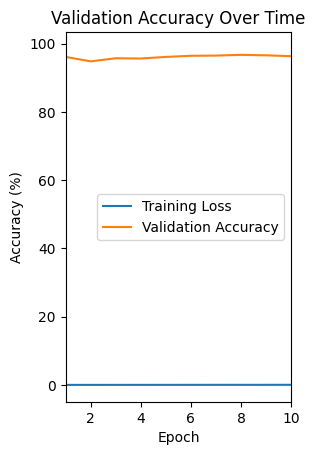

In [9]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [10]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Extract the actual predictions from the tuple
        actual_outputs = outputs[0]
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE) for ID BEFORE CALIBRATION: {ece:.4f}")


probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Extract the actual predictions from the tuple
        actual_outputs = outputs[0]
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE) for OD data BEOFRE CALIBRATION: {ece:.4f}")

Expected Calibration Error (ECE) for ID BEFORE CALIBRATION: 0.0190
Expected Calibration Error (ECE) for OD data BEOFRE CALIBRATION: 0.0429


In [11]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, features = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift, for cifar, the test data is the OD data
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 97.02%
Average Test Loss: 0.1426


In [12]:
accuracy, avg_loss = evaluate(model,OD_loader, device) # change the data here to experience concept drift, for cifar, the test data is the OD data
print(f"Test Accuracy for out of distribution data: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy for out of distribution data: 93.80%
Average Test Loss: 0.2493


In [13]:
import numpy as np
def extract_features(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    feature_list = []

    with torch.no_grad():
        for inputs, _ in dataloader:  # we don't need labels for this
            inputs = inputs.to(device)
            _, features = model(inputs)
            features = features.view(features.size(0), -1).cpu().detach().numpy()
            feature_list.append(features)

    return np.vstack(feature_list)

# Extract all features from training data
train_features_all = extract_features(model, train_loader, device)

In [14]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
# Calculate density estimates(can be extended to multiple layers)
w = torch.tensor([1.0], requires_grad=True, device=device)
w0 = torch.tensor([1.0], requires_grad=True, device=device)
# w, w0: Learned parameters for adjusting the logits based on density.


def compute_density_estimates(train_features, test_features, k=50):
    # Convert train_features to numpy if they are tensors
    train_features = train_features.cpu().numpy() if isinstance(train_features, torch.Tensor) else train_features
    test_features = test_features.cpu().numpy() if isinstance(test_features, torch.Tensor) else test_features

    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(train_features)
    distances, _ = nn.kneighbors(test_features)
    return distances[:, -1]

def adjust_logits_with_density(logits, densities, w, w0):
    # Ensure densities are a 2D tensor with shape [batch_size, 1]
    densities = densities[:, None] if densities.ndim == 1 else densities
    # Compute scaling factor S with shape [batch_size, 1]
    S = densities * w + w0
    # Adjust logits - this should now broadcast correctly
    adjusted_logits = logits / S
    return adjusted_logits


def squared_loss(logits_adjusted, labels):
    Ic = torch.nn.functional.one_hot(labels, num_classes=logits_adjusted.shape[1])
    probs = torch.nn.functional.softmax(logits_adjusted, dim=1)
    loss = ((Ic.to(device) - probs) ** 2).sum()  # Move Ic tensor to the same device as probs
    return loss

# Optimization of the weights w and bias w0 on a validation set
def optimize_weights_bias(model, val_loader, device, epochs=20, lr=1e-6): # epoch here should be at least 10(maybe even up to 50 but I stopped it since it takes forever to train), but bear in mind it takes forever to calibrate
    optimizer = optim.SGD([w, w0], lr=lr) # stochastic optimization for the bias and weights
    for epoch in range(epochs):
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, val_features = model(inputs)
            val_features = val_features.view(val_features.size(0), -1).cpu().detach().numpy()
            densities = compute_density_estimates(train_features_all, val_features)
            densities = torch.tensor(densities, dtype=torch.float32, device=device)  # Convert numpy array to tensor
            logits_adjusted = adjust_logits_with_density(outputs, densities, w, w0)  # Avoid detaching outputs to CPU
            loss = squared_loss(logits_adjusted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [15]:
import torch.optim as optim

# Define Temperature Scaling Module
class TemperatureScaling:
    def __init__(self, model, initial_temp=1.0, device='cpu'):
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = device
        self.temperature = torch.nn.Parameter(torch.ones(1, device=self.device) * initial_temp)

    def nll_loss(self, logits, labels): #negative log likelihood losss
        return torch.nn.functional.cross_entropy(logits, labels)

    def optimize_temperature(self, val_loader, lr=1e-6, epochs=20):  # optimal number of epoch is way more than this but calibration takes forever
        optimizer = optim.LBFGS([self.temperature], lr=lr) # LBFGS optimization for the termperature scaling
        def closure():
            optimizer.zero_grad()
            loss_total = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                with torch.no_grad():
                    outputs, _ = self.model(inputs)
                scaled_logits = outputs / self.temperature
                loss = self.nll_loss(scaled_logits, labels)
                loss_total += loss.item()
                loss.backward()
            return loss

        # Run the optimization loop
        for epoch in range(epochs):
            optimizer.step(closure)

    def scale(self, logits):
        return logits / self.temperature.detach()

def calibrate_and_evaluate(model, val_loader, test_loader, device, num_forward_passes=10):
    # Optimize w and w0 using the DAC method
    model.to(device)
    optimize_weights_bias(model, val_loader, device)

    # Initialize temperature scaling with the current model
    temp_scaling = TemperatureScaling(model, device=device)
    # Optimize the temperature with the validation set
    temp_scaling.optimize_temperature(val_loader)

    correct = 0
    total = 0

    # Perform DAC and temperature scaling calibration
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)  # Ensure labels are on the same device as predictions
            outputs_list = []
            features_list = []  # List to store features for each forward pass

            for _ in range(num_forward_passes):
                outputs, features = model(inputs)
                outputs_list.append(outputs)
                features_list.append(features.view(features.size(0), -1))  # Flatten features here

            # Average the outputs and features from all forward passes
            outputs_mean = torch.mean(torch.stack(outputs_list), dim=0)
            features_mean = torch.mean(torch.stack(features_list), dim=0)  # Average the features

            # Assuming train_features_all and test_features are NumPy arrays
            # You should compute density estimates outside this loop and pass them to this function
            densities = compute_density_estimates(train_features_all, features_mean.cpu().numpy())  # Now this should be a 2D array
            densities_tensor = torch.from_numpy(densities).float().to(device)

            logits_adjusted_dac = adjust_logits_with_density(outputs_mean, densities_tensor, w, w0)
            logits_adjusted_temp = temp_scaling.scale(logits_adjusted_dac)

            _, predicted_adjusted = torch.max(logits_adjusted_temp, 1)
            total += labels.size(0)
            correct += (predicted_adjusted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Call the function to calibrate and evaluate
accuracy = calibrate_and_evaluate(model, val_loader, test_loader, device)
print(f"Accuracy after DAC and temperature scaling on test dataset: {accuracy * 100:.2f}%")


Accuracy after DAC and temperature scaling on test dataset: 97.02%


In [ ]:
import torch.nn.functional as F
# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Extract the actual predictions from the tuple
        actual_outputs = outputs[0]
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")


In [ ]:
# Sample test result and current datetimeimport json
import json
from datetime import datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_cifar_dactemp.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-53a0dfd22475>", line 10, in <cell line: 10>
    with open('results_ECE_cifar_dactemp.json', 'a') as file:
OSError: [Errno 107] Transport endpoint is not connected: 'results_ECE_cifar_dactemp.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities for all classes
        probs = F.softmax(logits, dim=1)

        # Store probabilities and labels
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
correctness = np.array(correctness)
predicted_probs = np.array(predicted_probs)

# Calculate AUROC for each class and average them
auroc = roc_auc_score(correctness, predicted_probs, multi_class='ovr')
print(f"Average AUROC for multi-class: {auroc:.4f}")


In [ ]:
# Sample test result and current datetime
result_auroc = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_auroc_dactemp_cifar.json', 'a') as file:
    file.write(json.dumps(result_auroc) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-1eaa8f2311b8>", line 8, in <cell line: 8>
    with open('results_auroc_dactemp_cifar.json', 'a') as file:
OSError: [Errno 107] Transport endpoint is not connected: 'results_auroc_dactemp_cifar.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lin

OD below
When calculating the Expected Calibration Error (ECE) of a model, especially after training on In-Distribution (ID) data, the labels of the Out-of-Distribution (OD) data are not necessary if you are specifically assessing the model's calibration on OD data alone. This is because ECE focuses on the relationship between predicted probabilities (confidence) and actual correctness, rather than class-specific performance.

In [ ]:
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Extract the actual predictions from the tuple
        actual_outputs = outputs[0]
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece_OD = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

In [ ]:
# Sample test result and current datetime
ece_OD = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": ece_OD  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ece_dactemp_cifar_OD.json', 'a') as file:
    file.write(json.dumps(ece_OD) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-4f1090f95803>", line 8, in <cell line: 8>
    with open('results_ece_dactemp_cifar_OD.json', 'a') as file:
OSError: [Errno 107] Transport endpoint is not connected: 'results_ece_dactemp_cifar_OD.json'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_l